In [10]:
import os
import desispec.io
import fitsio

from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt

#from chainconsumer import ChainConsumer
import corner

In [9]:
%set_env DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
%set_env SPECPROD=andes
reduxdir = desispec.io.specprod_root()
print(reduxdir)

env: DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux
env: SPECPROD=andes
/global/cfs/cdirs/desi/spectro/redux/andes


In [11]:
def MgII_Model(theta,x):
    z,a1,a2,s1,s2,m,b=theta
    #determine peak centers
    m1=(z+1)*2795.5301
    m2=(z+1)*2802.7056
    
    #Generate Model
    model = m*(x-x[0]) +b + a1*np.exp((-(x-m1)**2)/(2*s1**2))+a2*np.exp((-(x-m2)**2)/(2*s2**2))
    return model

In [12]:
#Simple Chi-Sq function
#Isn't this basically identical to log_likelihood?

def chisq(observed,calculated,error):
    #Basic sum over all
    return(np.sum((observed - calculated) ** 2 / error ** 2))


In [13]:
#likelihood fnc
def log_likelihood(theta, x, y, yerr):
    #generative model
    model = MgII_Model(theta,x)
    #error into variance
    sigma2 = yerr **2
    #Actual Likelihood fnc
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [14]:
#get spectrum from targetid

def get_spec(targetid,tile,date,to_print=False):
    dirn = os.path.join(reduxdir, "tiles", tile, date)
    for spectrograph in range(10):
        fn = "coadd-{}-{}-{}.fits".format(spectrograph, tile, date)
        file = os.path.join(dirn, fn)
        fmap = fitsio.read(file, "FIBERMAP")
        for i in range(500):
            if(str(fmap['TARGETID'][i]) == targetid):
                specnum = i
                fnstore=fn
                spectrographstore = spectrograph
                if(to_print):
                    print(fn,spectrograph,i)
    specfn = os.path.join(dirn, fnstore)
    specobj = desispec.io.read_spectra(specfn)
    
    if("brz" in specobj.wave):
        x_spc = specobj.wave["brz"]
        y_flx = specobj.flux["brz"][specnum]
        y_err=1/np.sqrt(specobj.ivar["brz"][specnum])
    #else combine into "brz" using helper fnc.
    else:
        x_spc,y_flx,y_err=quick_brz(specobj,specnum)
    
    return(x_spc,y_flx,y_err)

In [15]:
#Turn 'b', 'r', 'z' into 'brz'
def quick_brz(specobj,spectrum):
    #pull wavelength sections
    bw=np.round(specobj.wave['b'],3)
    rw=np.round(specobj.wave['r'],3)
    zw=np.round(specobj.wave['z'],3)
    
    #find overlapping arrays in wave
    br_overlap=np.intersect1d(bw,rw)
    rz_overlap=np.intersect1d(rw,zw)

    #find indices of overlapping regions
    br_start=int(np.where(bw==br_overlap[0])[0])
    br_end=int(len(bw))

    rz_start=int(np.where(rw==rz_overlap[0])[0])
    rz_end=int(len(rw))

    #pull flux
    bf=specobj.flux['b'][spectrum]
    rf=specobj.flux['r'][spectrum]
    zf=specobj.flux['z'][spectrum]
    #pull error
    be=1/np.sqrt(specobj.ivar['b'][spectrum])
    re=1/np.sqrt(specobj.ivar['r'][spectrum])
    ze=1/np.sqrt(specobj.ivar['z'][spectrum])
    #turn into 'brz'
    x_spc=np.concatenate((bw[:br_start],(bw[br_start:br_end]+rw[:br_end-br_start])/2,rw[br_end-br_start:rz_start],(rw[rz_start:rz_end]+zw[:rz_end-rz_start])/2,zw[rz_end-rz_start:]))
    y_flx=np.concatenate((bf[:br_start],(bf[br_start:br_end]+rf[:br_end-br_start])/2,rf[br_end-br_start:rz_start],(rf[rz_start:rz_end]+zf[:rz_end-rz_start])/2,zf[rz_end-rz_start:]))
    y_err=np.concatenate((be[:br_start],(be[br_start:br_end]+re[:br_end-br_start])/2,re[br_end-br_start:rz_start],(re[rz_start:rz_end]+ze[:rz_end-rz_start])/2,ze[rz_end-rz_start:]))
    
    return(x_spc,y_flx,y_err)

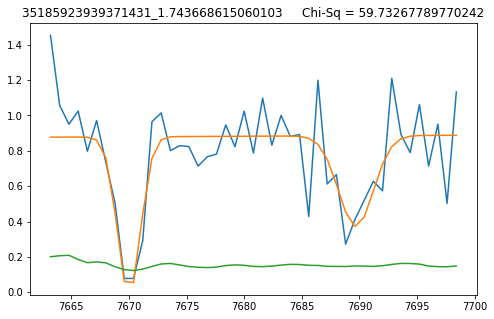

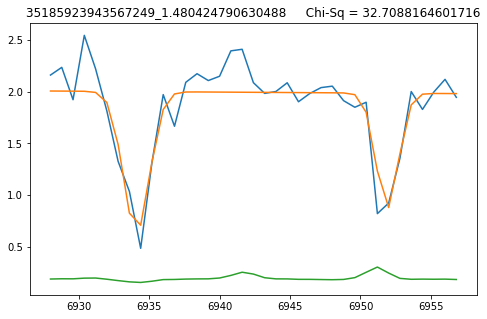

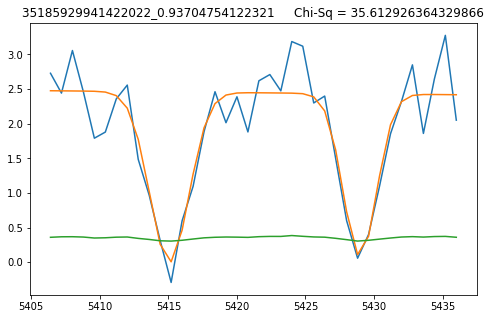

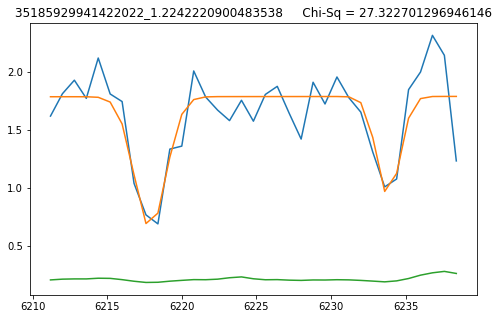

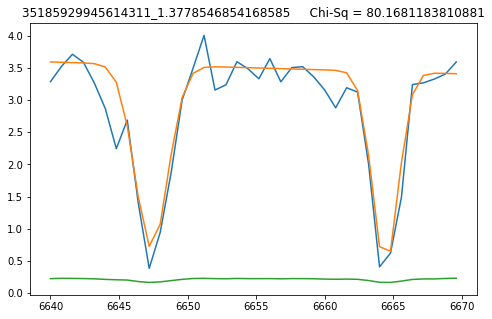

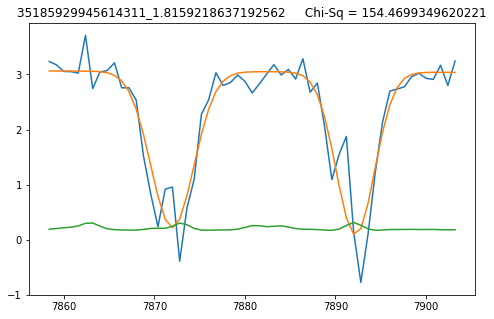

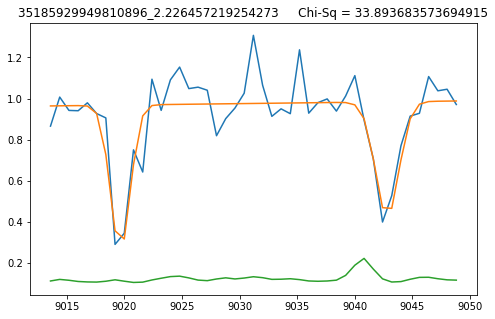

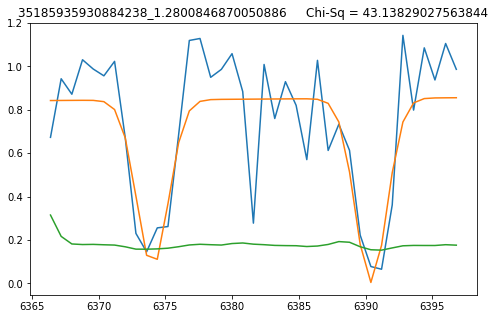

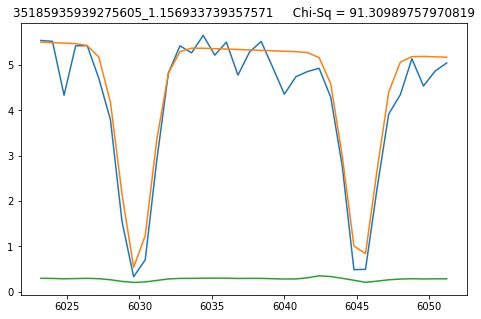

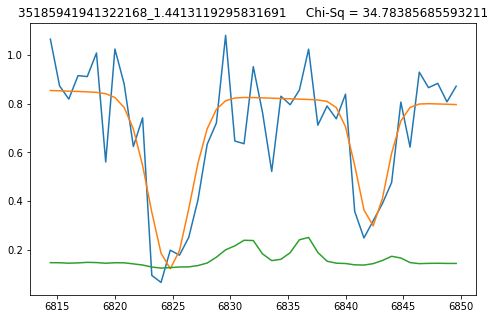

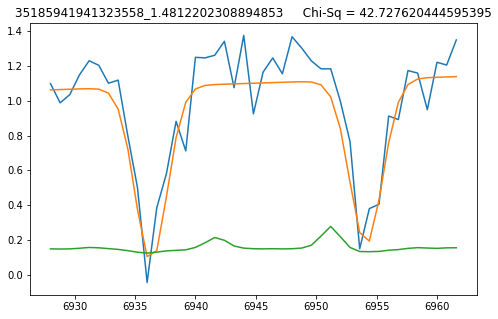

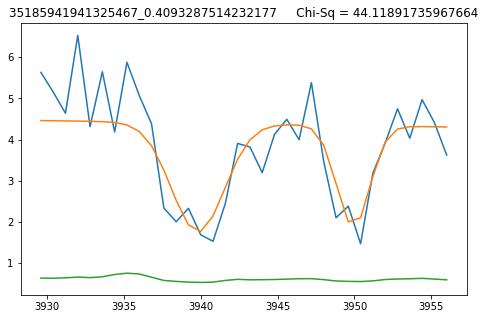

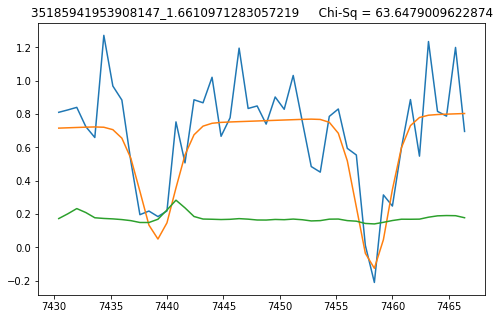

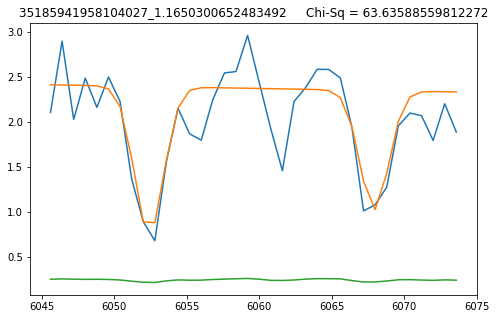

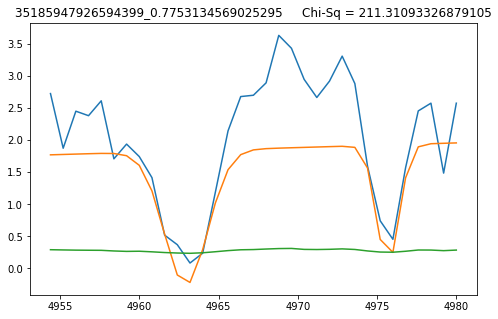

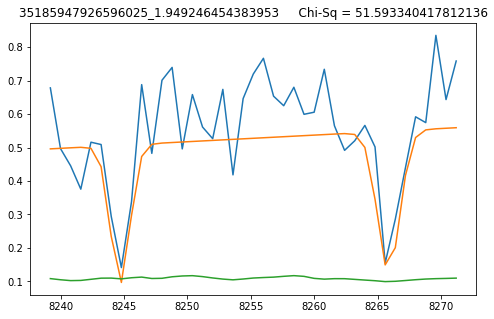

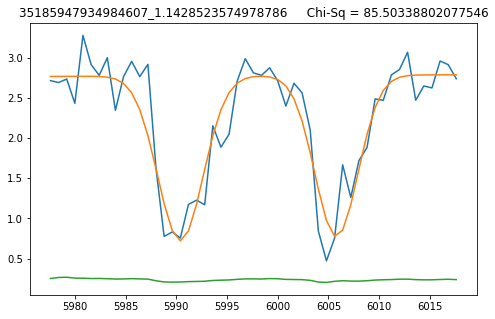

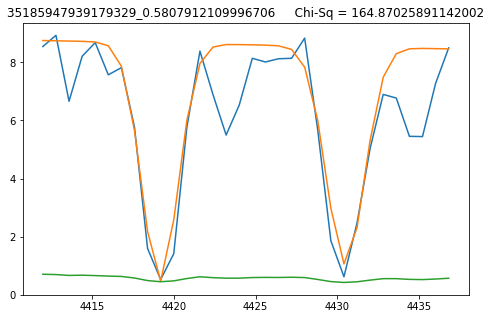

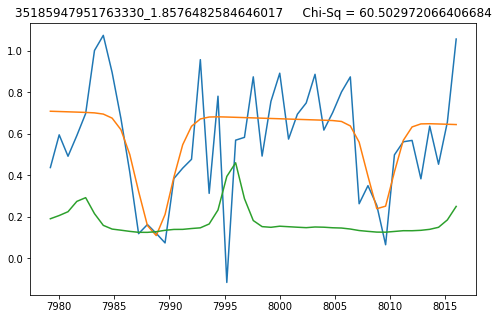

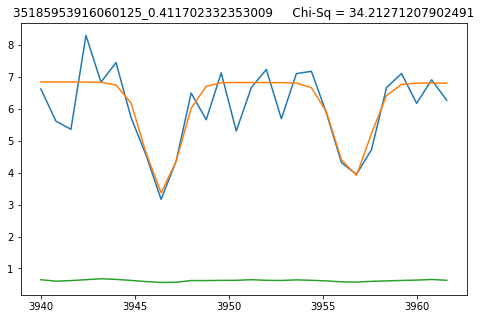

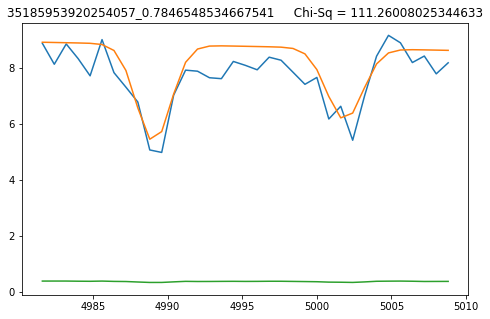

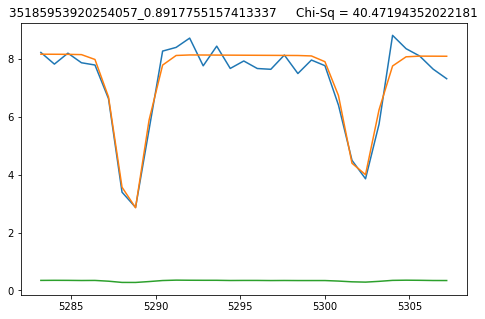

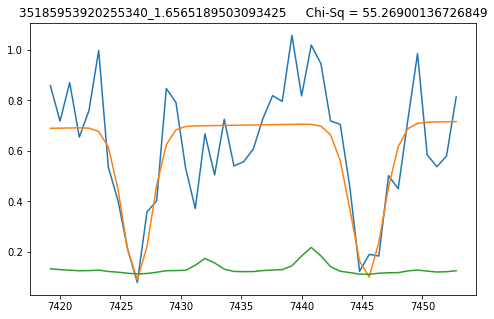

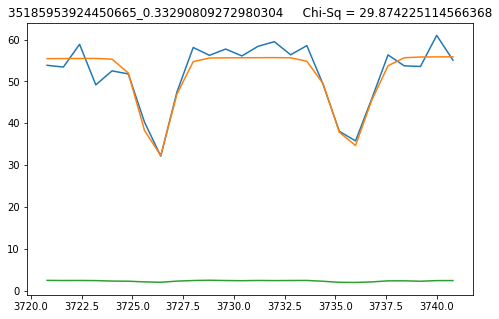

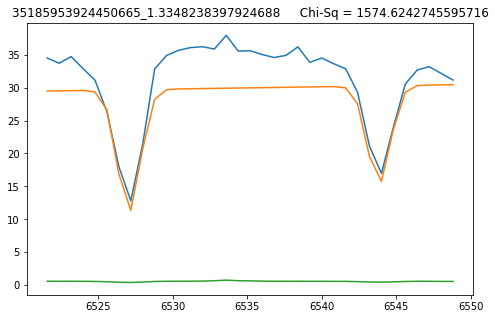

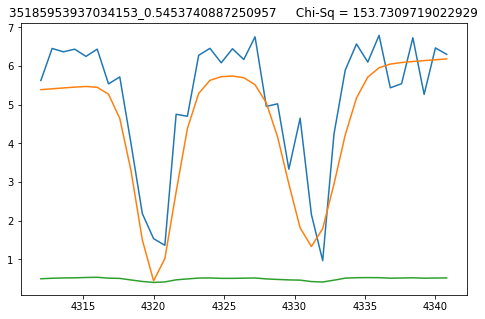

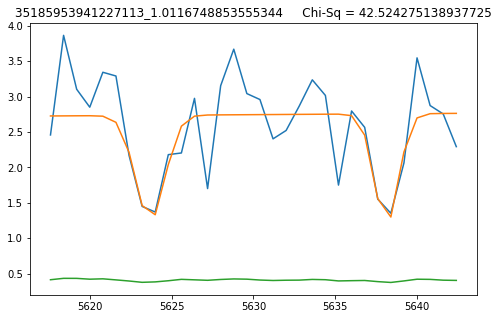

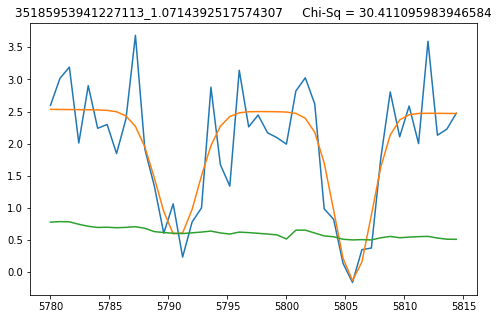

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


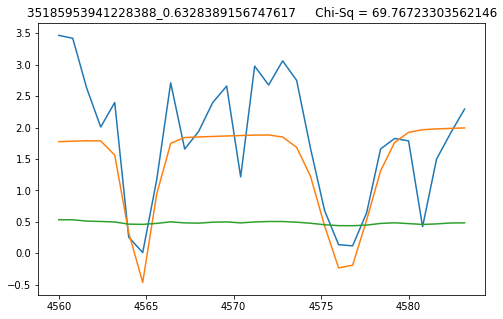

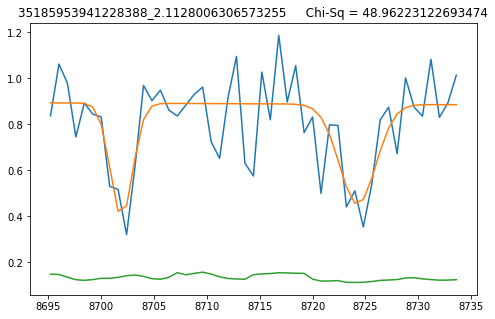

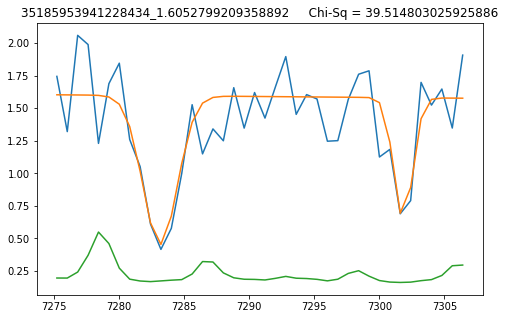

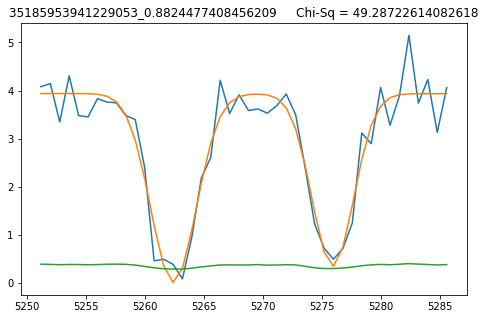

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide


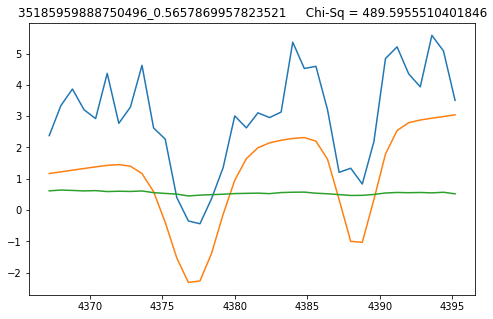

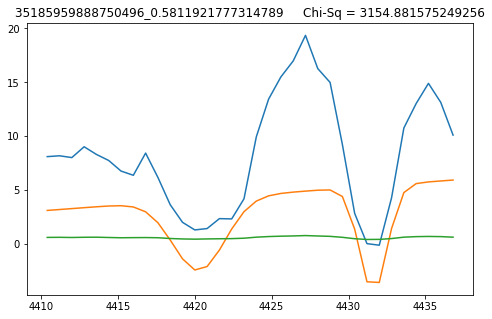

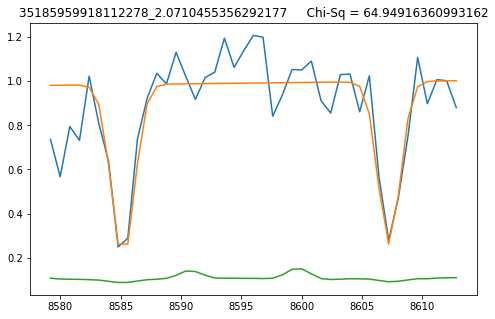

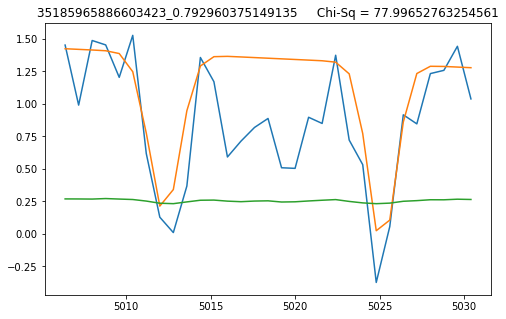

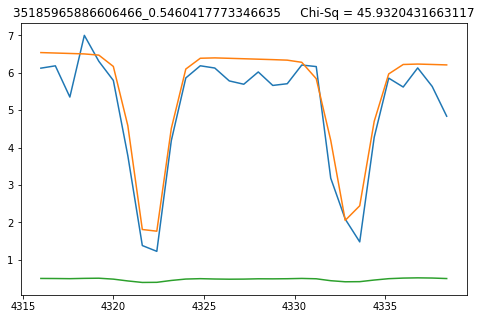

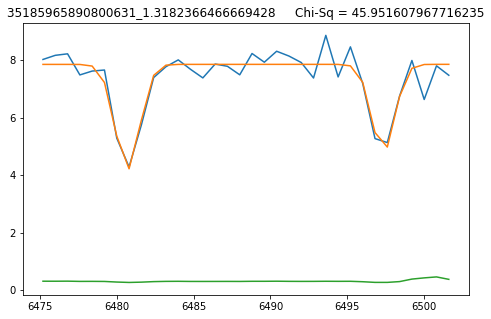

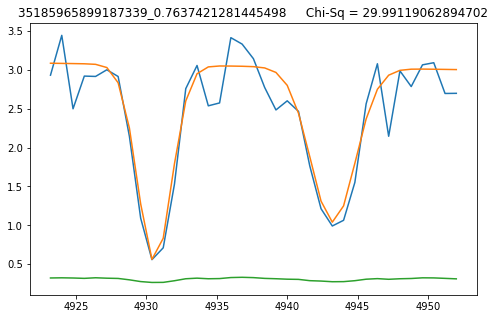

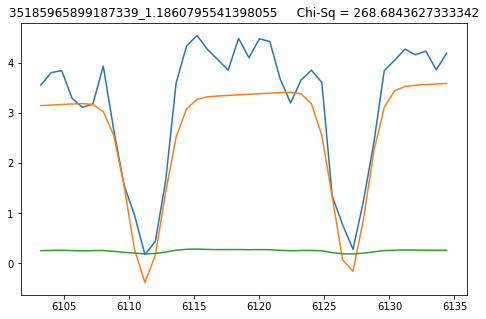

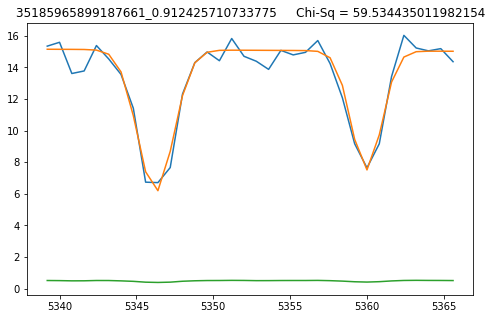

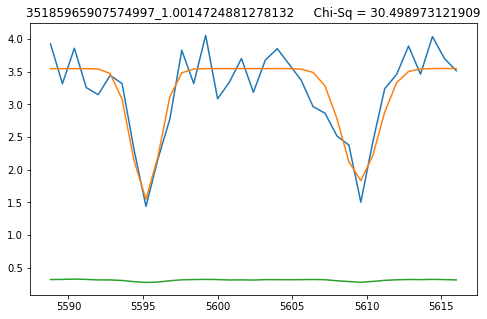

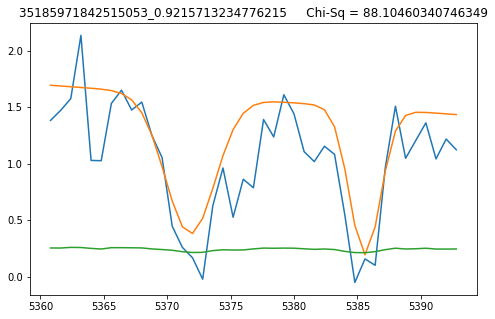

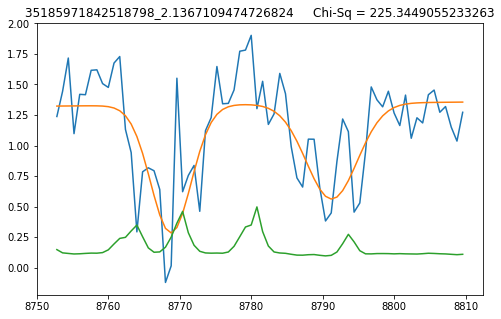

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide


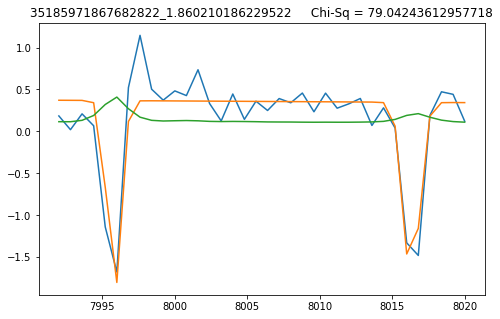

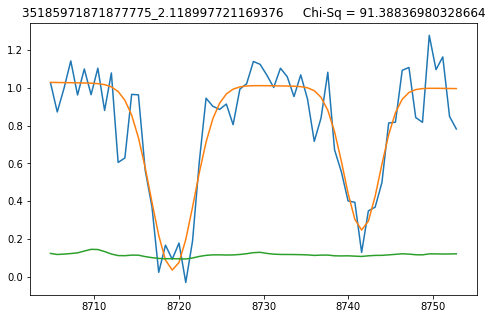

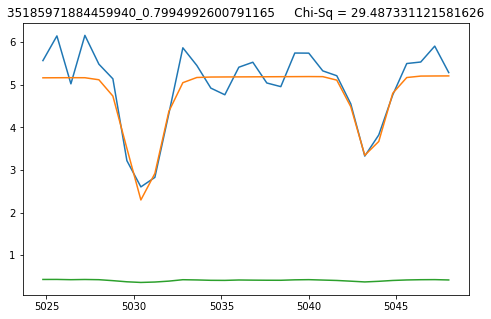

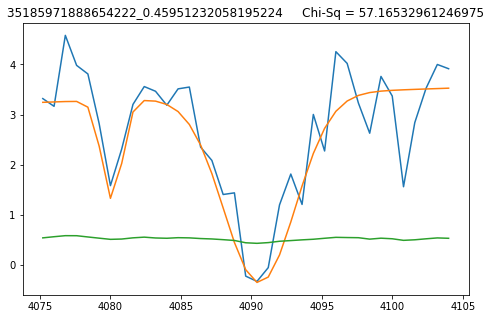

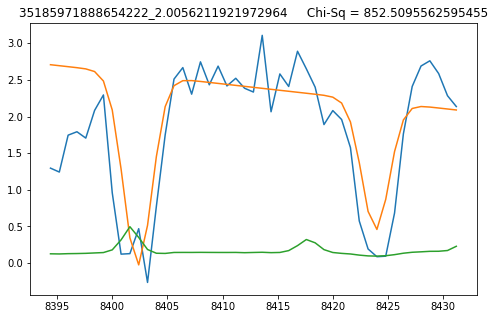

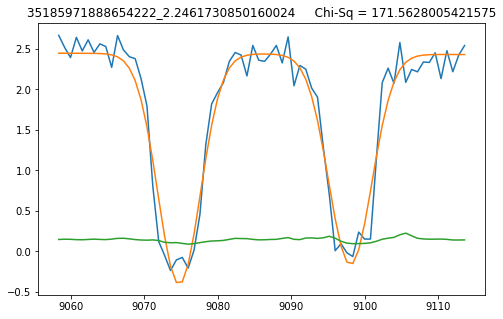

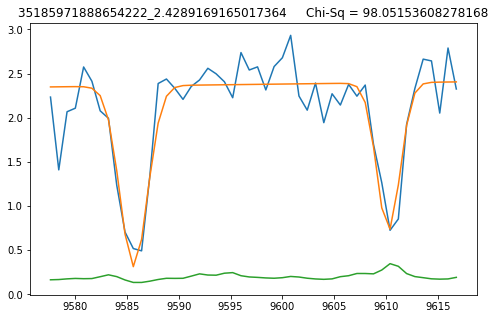

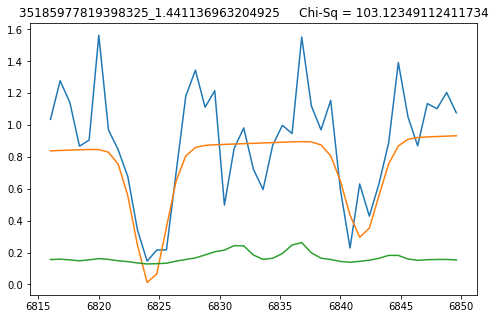

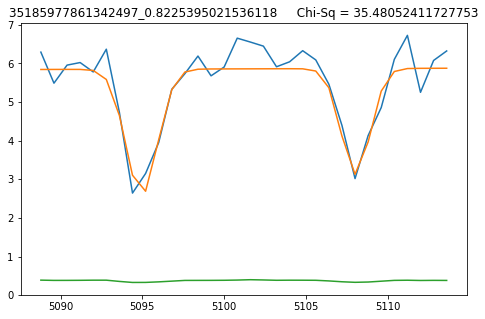

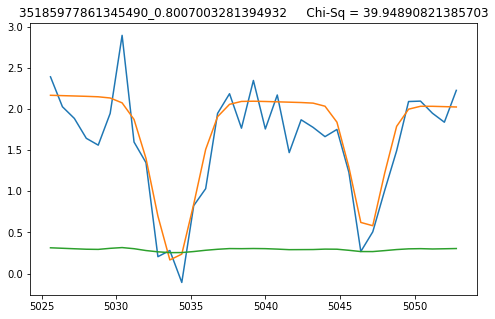

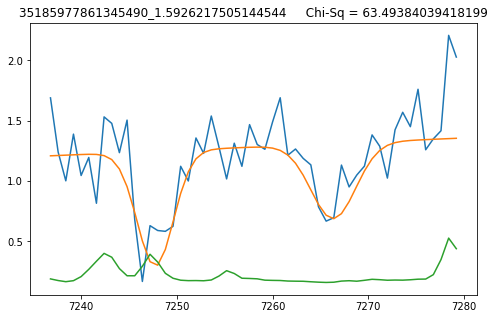

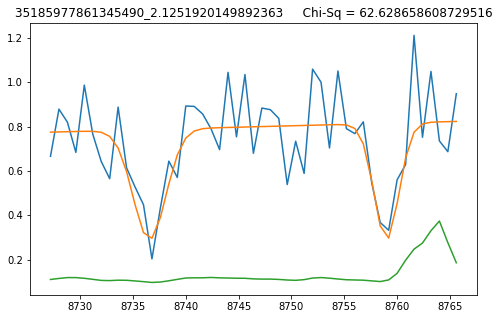

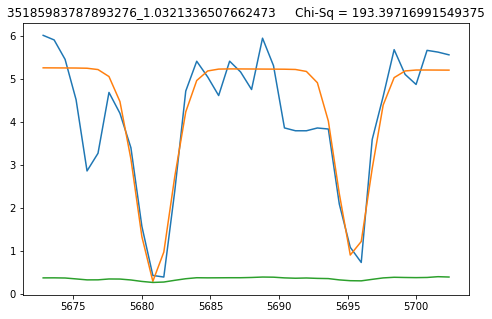

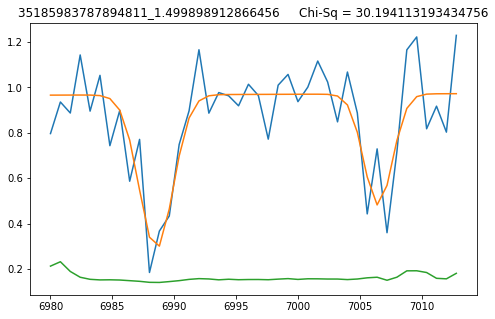

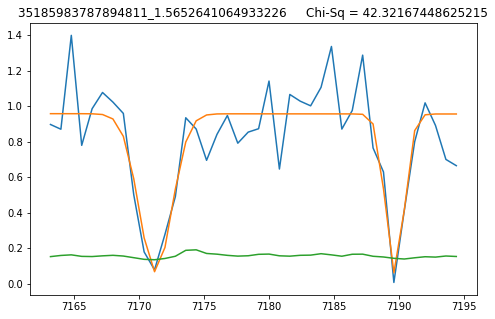

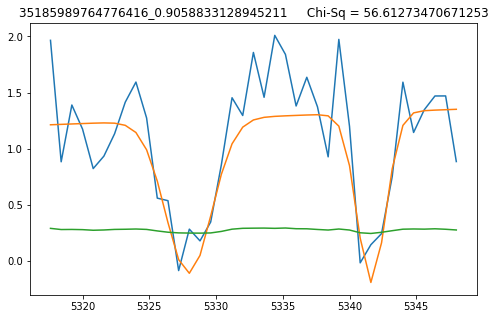

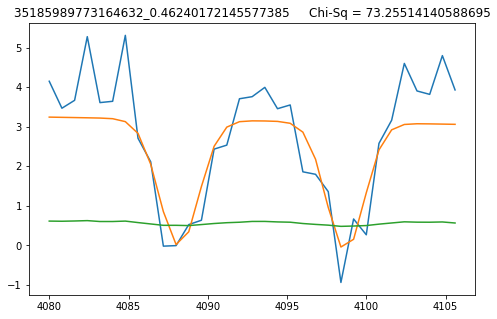

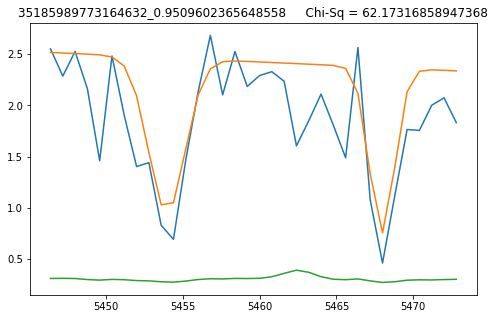

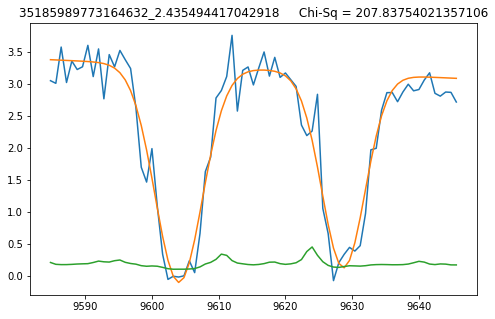

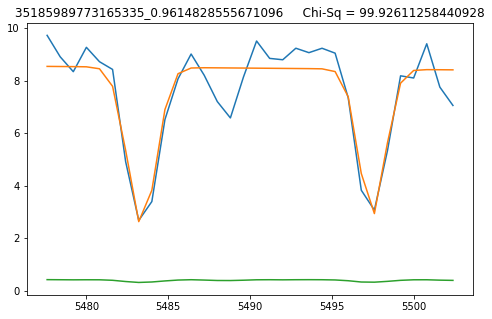

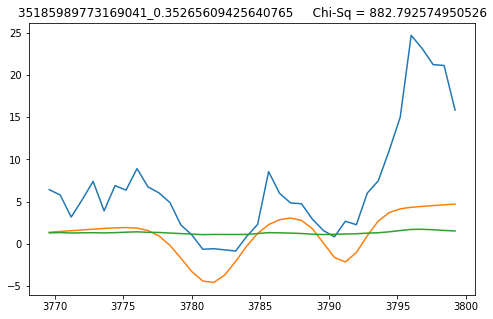

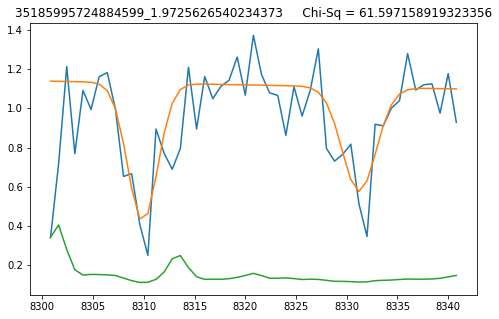

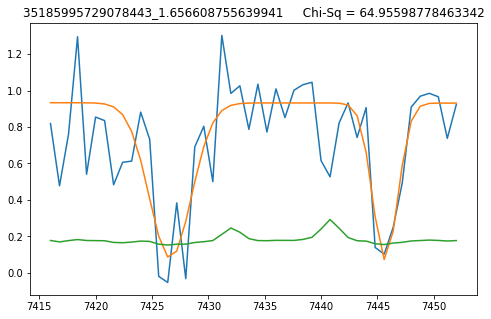

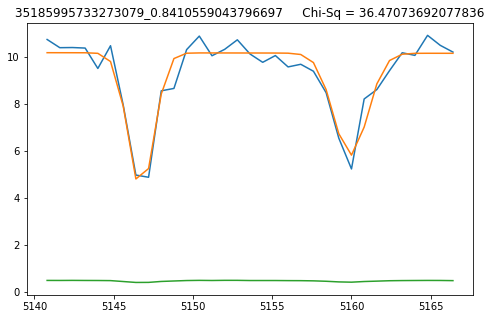

In [26]:
#labels=['Redshift','Amplitude_1','Amplitude_2','StdDev_1','StdDev_2']
ndim=7
labels = ['z','Amp1','Amp2','StdDev1','StdDev2','m','b']
all_features=[]

date='20200315'
tile='68002'

all_file = open("MgII_Candidate_Chains/allfiles.txt","r")

for line in all_file:
    #grab a line of input file
    TID_z=line.strip()
    #Run for all the good ones and a couple random ones
    #Placeholder condition
    if(np.random.rand()>0.00):
        #grab spectrum info based onTID_z.split('_')[0] TARGETID
        targetid=TID_z.split('_')[0]
        x_spc,y_flx,y_err = get_spec(targetid,tile,date)
        #Pull MCMC chain in
        flat_samples=np.genfromtxt('MgII_Candidate_Chains/'+TID_z,delimiter=',')
        #c.add_chain(flat_samples,name=TID_z,)
        
        #MCMC output
        cen_vals=np.zeros(ndim);low_vals=np.zeros(ndim);high_vals=np.zeros(ndim)
        for j in range(ndim):
            #extract percentile values, must be cleaner non-loop way to do this
            cen_vals[j]=np.percentile(flat_samples[:, j],50)
            low_vals[j]=np.percentile(flat_samples[:, j],16)
            high_vals[j]=np.percentile(flat_samples[:, j],84)
            
        #out_str=[targetid,cen_vals[0],cen_vals[1],cen_vals[2],cen_vals[3],cen_vals[4],cen_vals[5],cen_vals[6]]
        #print(out_str)
        #wavelength bounds of peak region based on cen_vals
        high_wave=(cen_vals[0]+1)*2802.7056+cen_vals[4]*5
        low_wave= (cen_vals[0]+1)*2795.5301-cen_vals[3]*5
        #recast into index space for slicing, 2 is a fudge factor for low StdDev peaks
        prh=min(len(x_spc)-1, int(np.round((high_wave-3600)/0.8)))+2
        prl=max(0, int(np.round((low_wave-3600)/0.8)))-2
        
        #cont_est = medfilt(y_flx,19)
        #calculate residual
        #residual = cont_est-y_flx

        all_features.append(np.concatenate(([targetid],cen_vals)))
        #slice peak region
        peak_wave=x_spc[prl:prh]
        peak_flx=y_flx[prl:prh]
        peak_err=y_err[prl:prh]

        #make models from MCMC output
        cen_fit_model = MgII_Model(cen_vals,peak_wave)
        plt.figure(figsize=(8,5))
        plt.title(TID_z.strip('.csv')+"     Chi-Sq = "+str(chisq(peak_flx, cen_fit_model, peak_err)))
        plt.plot(peak_wave,peak_flx)
        plt.plot(peak_wave,cen_fit_model)
        plt.plot(peak_wave,peak_err)
        plt.show()
        
np.savetxt('MgII_Feature_Params.csv', all_features, delimiter=",",fmt='%s')
#fig = corner.corner(flat_samples, labels=labels)
#table = c.comparison.comparison_table(caption="Model comparisons!")
#print(table)